# Prise en compte de la simulation précédente 



### Parameters

In [1]:


import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None
import geopandas as gpd
from pathlib import Path
import folium
from shapely.geometry import Polygon, Point, LineString

#Parameters 
overwrite = True
showmap = False

data_sources_paths_fr =  {
   "sirene": Path(r"C:\Users\J0102113\Documents\a-SIGetWeb\AO\mul\datas\m2a_base-sirene-v3-consolidee-insee.geojson"),
    "populationDataset_fr": Path(r"C:\Users\J0102113\Documents\a-SIGetWeb\AO\mul\datas\base-ic-evol-struct-pop-2017.CSV"),
    "shapes_IRIS_2013" : Path(r"C:\Users\J0102113\Documents\a-SIGetWeb\AO\mul\datas\iris-2013-01-01.zip"),
    "bemo_stations": Path(r"C:\Users\J0102113\Documents\a-SIGetWeb\AO\mul\datas\bemo2112_fr.csv"),
    "m2a_communes" : Path(r"C:\Users\J0102113\Documents\a-SIGetWeb\ao\mul\datas\m2a_communes-sur-le-territoire-m2a.geojson"),
    "bemo_stations1":Path(r"C:\Users\J0102113\Documents\a-SIGetWeb\ao\mul\datas\stations_supp_aomul220506.csv" ),
   "bemo_stations2":Path(r"C:\Users\J0102113\Documents\a-SIGetWeb\ao\mul\datas\Gagnantsfiltres220510.csv" )
 }
top_cities  = {'Mulhouse' : ( 7.335908, 47.7508)}
city =  'Mulhouse'
points = 42000 #Number of samples for each simulation run
#number_of_stations = 3 #Number of stations to keep overall
#assert number_of_stations < points
Influence = False #if the best stations influence each other
radius = 0.01 #buffers size
x_range, y_range = 0.3, 0.2 #limits of the bounding box (lon , lat)
#crs = 4326 # Degrees 
crs_proj = 2154 #2 d projections france
crs_joins = 4326 #For joining geodatagrames its better to use same crs
#crs = 3035
country_col_name = {"FR" : "IRIS" } #we have to change data based on the country
country = 'FR'
shapes_path_fr = Path(r"C:\Users\J0102113\Documents\a-SIGetWeb\AO\mul\datas\shapes_fr.pq")
logs_path = Path(r"C:\Users\J0102113\Documents\a-SIGetWeb\AO\mul\datas\logs.pq")


output_path = Path(r"C:\Users\J0102113\Documents\a-SIGetWeb\AO\mul\datas\interim\best_stations3.csv")
#ref_output_path = Path(r"C:\Users\J0102113\Documents\a-SIGetWeb\AO\mul\datas\transmises\tr2\refplayers220513.csv")

In [2]:

class attraction(): 
  ''' Generate points and shapes for the simulations'''

  def generate_rectangle(rect_center: list, x_range: float  , y_range :float )-> dict: 
    '''We genereate a rectangle around the point '''
    limits = {'xmin' : rect_center[0]-x_range, 'xmax' : rect_center[0]+ x_range, 
              'ymin' : rect_center[1]-y_range,  'ymax' : rect_center[1]+ y_range}
    print(f"Limits : {limits}")          
    return limits

  def convert_to_gdf(limits: dict, crs : int)-> gpd.GeoDataFrame(): 
    '''We generate a one line geodataframe to facilitate geo intersection with other gdfs.
    Limits must possess xmin, xmax, ymin, ymax keys''' 
    polys1 = gpd.GeoSeries([Polygon([(limits['xmin'],limits['ymin']), (limits['xmax'],limits['ymin']), 
                                  (limits['xmax'],limits['ymax']), (limits['xmin'],limits['ymax'])])])
    gpd_ = gpd.GeoDataFrame({'geometry': polys1, 'not_used':[1]}, crs=crs)

    return gpd_

  def generate_points(limits: dict , crs : int , points : int = 3 )-> gpd.GeoDataFrame(): 
    '''We genereate a random number of points in the area defined in limits
      CRS is a 2  d projection so a distance and not degrees
    '''
    xc = (limits['xmax'] - limits['xmin']) * np.random.random(points) + limits['xmin']
    yc = (limits['ymax'] - limits['ymin']) * np.random.random(points) + limits['ymin']

    points_list = [Point(x, y) for x, y in zip(xc, yc)]
    default_index = [i for i in range(len(points_list))]

    gpd_ = gpd.GeoDataFrame({'nameofsample': default_index, 'geometry' : points_list,} , crs=crs)

    return gpd_

  def generate_buffer(gpd_: gpd.GeoDataFrame() , distance: float  , crs : int, resolution: int = 4  ):
    '''we  generate a buffer based on distance '''
    gpd_['buffer'] = gpd_["geometry"].buffer(distance = distance, resolution = 4).to_crs(crs)
    gpd_.rename(columns={'geometry':'geom_points', 'buffer':'geometry'}, inplace=True) #buffer as geometry

    return gpd_

  def generate_buffers(gdf_ : gpd.GeoDataFrame, point1 : str = 'sample_point', point2 : str = 'neighborhood_centroid' ) -> gpd.GeoDataFrame : 
    "Generate buffers with distances from sample to centroids using geopandas"
    gdf_['distances'] = gdf_[point1].distance(gdf_[point2], align=True)
    print('ok')
    gdf_['buffers'] = gdf_[point2].buffer(distance = gdf_['distances'], resolution = 4) #.to_crs(crs)

    return gdf_

######

class prepareShapes:
    def __init__(self, data_sources_paths: dict ):
        self.data_sources_paths = data_sources_paths

    def load_gdf(self, key: str, joining_col : str )-> gpd.GeoDataFrame :
      """helper to load a geodataframe - works with geojson and shapefiles"""
      gdf = gpd.read_file(self.data_sources_paths[key], 
                              dtype={joining_col: str})
      return gdf

    def load_df(self, key: str, joining_col : str, zipped : bool = False) -> pd.DataFrame :
        """Enables to load the attributes dataframe specific to France & Germany"""
        if not zipped : 
          df = pd.read_csv(self.data_sources_paths[key], 
                                    sep=',', dtype={joining_col: str})
        else :
          zf = zipfile.ZipFile(self.data_sources_paths[key])

        return df


class mergeShapes:
  """class to regroup geographical joins
  """
  def prepare_osm_gdf(gdf: gpd.GeoDataFrame, keep_cols: list ) -> gpd.GeoDataFrame : 
      """Prepare the geodataset that enables to have competition:  filter colums, identify own installations, and creating a joining col"""

      #1- filter colums : keep only columns that are not too empty
      gdf_ = gdf[keep_cols] 

      #2- try to identify Total stations based on two other columns
      gdf_["brand"] = gdf_["brand"].fillna("Unknown")
      gdf_["name"] = gdf_["name"].fillna("Unknown")
      
      gdf_['is_mine_brand'] = gdf_["brand"].str.contains("total", case=False) 
      gdf_['is_mine_name'] = gdf_["name"].str.contains("total", case=False)
      gdf_['is_mine'] = (gdf_['is_mine_brand']) | (gdf_['is_mine_name'])
      gdf_.drop(['is_mine_brand', 'is_mine_name'], axis=1, inplace=True)

      #3- copy the geometry for later geographical joins
      gdf_['node_coord'] = gdf_['geometry'] 

      return gdf_

  def geofilter_rectangle(gdf_bbox, gdf_comp) : 
      '''geofilters to the bounding box and we rename a new geometry columns for osm points'''
      gdf_ = gpd.sjoin(gdf_bbox, gdf_comp, how="left", predicate='intersects')
      gdf_.drop(['geometry', 'index_right'], axis=1, inplace=True)

      return gdf_

  def geofilter_plz(gdf, gdf2, osm_cols) : 
      """geofilters competition within the plz shapes"""
      gdf = gpd.sjoin(gdf, gdf2, how="inner", predicate='intersects')
      gdf.drop(['index_right', 'not_used'], axis=1, inplace=True)

      gdf = gdf[osm_cols]
      return gdf

  def geofilter_buffers(gpd1, gpd2, osm_cols): 
    """geofilters competition within buffer circle
    gpd1 contains the buffers gpd2 contains the points"""

    gpd2['competitor_geom'] = gpd2['geometry']
    gpd1 = gpd1.loc[:, ["buffers",  "nameofsample", "plz"] ]
    gpd1.rename(columns={'buffers':  'geometry'}, inplace=True) 

    gpd_ = gpd.sjoin(gpd1, gpd2, how="inner", predicate='intersects')
    gpd_ = gpd_[osm_cols]

    return gpd_


#### Helpers for visualisations

def prepare_points(gdf, geometry_col, ):
    """Helper function to plot folium points """
    gdf = gdf.set_geometry(geometry_col)
    points = [[point.xy[1][0], point.xy[0][0]] for point in gdf.geometry ]
    return points

def prepare_attributes(gdf, attrib_cols):
    """Helper function to plot folium points """
    attributes = {}
    for col_name in attrib_cols : 
        attributes[col_name] = list(gdf[col_name])
    return attributes

def html_popup(i, attributes):
    """Helper function to plot folium points """
    popup_html = str()
    for key, value in attributes.items() :
        popup_html += f"{key}: {str(value[i])} " +  '<br> '
    return popup_html


In [3]:
#Generate samples geodataframe (geometry set on buffer polygons)
#We create and a bounding rectangle around it.
limits_dict = attraction.generate_rectangle(top_cities[city], x_range = x_range , y_range = y_range)
#We place (p) points chosen randomly within the boundaries of the rectangle.
samples_gdf = attraction.generate_points(limits_dict, crs = crs_proj, points  = points )
#From each of these points we create a buffer circle of radius (r) 
samples_gdf = attraction.generate_buffer(samples_gdf, distance = radius, crs = crs_proj)
samples_gdf.rename(columns={'geometry':'sample_buffer', 'geom_points':'sample_point'}, inplace=True)  

Limits : {'xmin': 7.035908, 'xmax': 7.635908, 'ymin': 47.550799999999995, 'ymax': 47.9508}


## Map1 : points randomly and created with influence area around

In [4]:
if showmap: 
    m = folium.Map(location=[top_cities[city][1],top_cities[city][0]] )
    #####
    _gdf = samples_gdf
    geometry_col = "sample_point"
    attrib_cols = ["nameofsample"]

    fg = folium.FeatureGroup("samples")

    points = prepare_points(_gdf, geometry_col  )
    attributes = prepare_attributes(_gdf,attrib_cols )

    for i , coordinates in enumerate(points):
        fg.add_child(folium.Marker(
            location = [coordinates[0],coordinates[1]],
            popup = html_popup(i ,attributes ),
            icon=folium.Icon(color='blue', icon='question', prefix='fa'))
        )
    fg.add_to(m)
    ##### Buffer
    _gdf = samples_gdf
    geometry_col = "sample_buffer"

    fg = folium.FeatureGroup(geometry_col)

    _gdf = _gdf.set_geometry(geometry_col)

    for _, r in _gdf.iterrows():
        sim_geo = gpd.GeoSeries(r[geometry_col])
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data=geo_j,
                            style_function=lambda x: {'fillColor': 'orange'})
        geo_j.add_to(fg)
    fg.add_to(m)
    #####
    folium.LayerControl().add_to(m)
    
    display(m)

In [5]:
#We prepare country geodataframe 

#Instanciation
shapes = prepareShapes(data_sources_paths_fr)

#load shapes of neighborhoods
#shape_gdf = shapes.load_gdf('shapes_IRIS_2013', country_col_name[country])
#shape_gdf.drop(['ORIGINE'], axis=1, inplace=True) #We do not know its purpose
#shape_gdf = shape_gdf.drop_duplicates(subset = ['DCOMIRIS']) #rows are repeated 10 times
#shape_gdf = shape_gdf.sort_values(by="DEPCOM")

#After anaysis we learned that we need to remove zero padded DCOM to merge with the population
#shape_gdf["DCOMIRIS"] = shape_gdf["DCOMIRIS"].str.lstrip('0')

# shape_gdf.to_parquet(shapes_path_fr)

shape_gdf = gpd.read_parquet(shapes_path_fr)

#we load the places population > can be saved to increase simulations speed
pop_df = pd.read_csv(data_sources_paths_fr["populationDataset_fr"], sep=';')
cols_to_keep = ['IRIS', 'COM', 'LAB_IRIS' ,  'P17_POP']
pop_df = pop_df[cols_to_keep]
pop_df['P17_POP'] = pop_df['P17_POP'].astype('int')
pop_df['IRIS'] = pop_df['IRIS'].astype('str')

#We merge shapes and population by district
country_gdf = pd.merge(left=shape_gdf, right=pop_df, left_on='DCOMIRIS',right_on = 'IRIS', how='left')
#Some places will not have matched with a population 
country_gdf.dropna(subset=['P17_POP'], inplace = True) # We should probably do a fill na by sorting by NOM_COM 
country_gdf['P17_POP'] = country_gdf['P17_POP'].astype('int')
country_gdf= country_gdf.drop(columns=["IRIS_x", "IRIS_y"])
print(f" Populations in districts without a shape that were deleted: {(1 - len(country_gdf)/ len(pop_df)):.1%}")
#print(f"% populations with no corresponding shapes: {(1 - len(pop_df)/ len(country_gdf)):.0%}")


 Populations in districts without a shape that were deleted: 0.5%


C:\Users\J0102113\AppData\Local\Temp\ipykernel_17560\1537527173.py:20: DtypeWarning: Columns (0,1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  pop_df = pd.read_csv(data_sources_paths_fr["populationDataset_fr"], sep=';')


In [6]:
#Spatially join neighborhoods with the sample points 
#attention dependency on rtree
cake_gdf = gpd.sjoin(country_gdf, samples_gdf.set_geometry('sample_buffer'), how="inner", predicate='intersects')
cake_gdf.rename(columns={'geometry':'neighborhood_shape'}, inplace=True)
cake_gdf.drop(['index_right'], axis=1, inplace=True)

C:\Users\J0102113\AppData\Local\Temp\ipykernel_17560\468883213.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:2154

  cake_gdf = gpd.sjoin(country_gdf, samples_gdf.set_geometry('sample_buffer'), how="inner", predicate='intersects')


In [7]:

#add centroids
cake_gdf['neighborhood_centroid'] = cake_gdf.set_geometry('neighborhood_shape').centroid
#add buffer circle around the centroids. the radius is based on distance from centroid to sample
cake_gdf = attraction.generate_buffers(cake_gdf, 'sample_point','neighborhood_centroid' )
#add a line between nodes and centroids
cake_gdf['line_to_sample'] = cake_gdf.apply(lambda x: LineString([x['neighborhood_centroid'], x['sample_point']]),axis=1)

print(f"Districts and Samples : {len(cake_gdf)}")

C:\Users\J0102113\AppData\Local\Temp\ipykernel_17560\4177540800.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cake_gdf['neighborhood_centroid'] = cake_gdf.set_geometry('neighborhood_shape').centroid
C:\Users\J0102113\AppData\Local\Temp\ipykernel_17560\1401814362.py:43: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:2154
Right CRS: EPSG:4326

  gdf_['distances'] = gdf_[point1].distance(gdf_[point2], align=True)


ok


C:\Users\J0102113\AppData\Local\Temp\ipykernel_17560\1401814362.py:45: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_['buffers'] = gdf_[point2].buffer(distance = gdf_['distances'], resolution = 4) #.to_crs(crs)
c:\Users\J0102113\Documents\a-SIGetWeb\AO\mul\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


Districts and Samples : 109534


In [8]:
iris_json = cake_gdf[['DCOMIRIS','neighborhood_shape']].sort_values(by='DCOMIRIS')#.head(2)
iris_json = iris_json.drop_duplicates()
iris_json = iris_json.rename(columns={"neighborhood_shape": "geometry"})

In [9]:
rename_geom_col = "neighborhood_shape"
property_cols = ["DCOMIRIS","NOM_IRIS","P17_POP"]

cp_json = cake_gdf[property_cols + [rename_geom_col]]
cp_json = cp_json.drop_duplicates()
cp_json = cp_json.rename(columns={"neighborhood_shape": "geometry"})
cp_json = gpd.GeoDataFrame(cp_json, crs=crs_joins)
cp_json = cp_json.to_json()

## 2-Map : Samples merged with Iris population

In [10]:
if showmap: 
    m = folium.Map(location=[top_cities[city][1],top_cities[city][0]] )

    ##### Points Layer
    _gdf = samples_gdf
    geometry_col = "sample_point"
    attrib_cols = ["nameofsample"]

    fg = folium.FeatureGroup("samples")

    points = prepare_points(_gdf, geometry_col  )
    attributes = prepare_attributes(_gdf,attrib_cols )

    for i , coordinates in enumerate(points):
        fg.add_child(folium.Marker(
            location = [coordinates[0],coordinates[1]],
            popup = html_popup(i ,attributes ),
            icon=folium.Icon(color='blue', icon='question', prefix='fa'))
        )
    fg.add_to(m)

    ###### Cloropleth Layer


    #Prepare json file for chloropleth map
    #https://www.roelpeters.be/plot-choropleth-map-geopandas-folium/
    iris_json = cake_gdf[['DCOMIRIS','neighborhood_shape']].sort_values(by='DCOMIRIS')#.head(2)
    iris_json = iris_json.drop_duplicates()
    iris_json = iris_json.rename(columns={"neighborhood_shape": "geometry"})
    iris_json = gpd.GeoSeries(iris_json.set_index('DCOMIRIS')['geometry']).to_json()


    cp = folium.Choropleth(
    geo_data=cp_json,
    data = cake_gdf,
    name='Population',
    columns=['DCOMIRIS','P17_POP'],
    key_on="feature.properties.DCOMIRIS",
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Population",
    highlight = True
    ).add_to(m)

    # and finally adding a tooltip/hover to the choropleth's geojson
    folium.GeoJsonTooltip(["NOM_IRIS","P17_POP"]).add_to(cp.geojson)


    ##### Buffer Layer
    geometry_col = "sample_buffer"

    fg = folium.FeatureGroup(geometry_col)

    _gdf = _gdf.set_geometry(geometry_col)

    for _, r in _gdf.iterrows():
        sim_geo = gpd.GeoSeries(r[geometry_col])
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data=geo_j,
                            style_function=lambda x: {'fillColor': 'orange'})
        geo_j.add_to(fg)
    fg.add_to(m)
    #####


    ##### IRIS Centroid Layer
    _gdf = cake_gdf
    geometry_col = "neighborhood_centroid"
    attrib_cols = ["NOM_IRIS","P17_POP" ]

    fg = folium.FeatureGroup("IRIS Centroids")

    points = prepare_points(_gdf, geometry_col  )
    attributes = prepare_attributes(_gdf,attrib_cols )

    for i , coordinates in enumerate(points):
        fg.add_child(folium.CircleMarker(
            location = [coordinates[0],coordinates[1]],
            popup = html_popup(i ,attributes ),
            radius = 1,
            color = "black")
        )
    fg.add_to(m)



    folium.LayerControl().add_to(m)

    display(m)

## 2- Other players in the area

In [11]:
def prep_bmo(df, bmo_cols, type): 
    "makes sure we have homogenuous dataframes to concatenate"
    df = df.loc[:,bmo_cols]
    df["type"] = type
    return df


def geoparse(_df, _crs):
    "we parse and add a backup colums because we lose geometry later in the joins "
    _gdf = gpd.GeoDataFrame(
        _df, geometry=gpd.points_from_xy(_df['longitude'], _df['latitude']), crs = _crs)
    _gdf["geometry_bkp"] = _gdf["geometry"]
    return _gdf


bmo_df = pd.read_csv(data_sources_paths_fr["bemo_stations"], sep = ";")
bmo_df_1 = pd.read_csv(data_sources_paths_fr["bemo_stations1"], sep = ";", encoding = "ISO-8859-1")
bmo_df_2 = bmo_df2 = pd.read_csv(data_sources_paths_fr["bemo_stations2"], sep = ";", encoding = "ISO-8859-1")
#we add name col to be homogenous
bmo_df_2["name"] = bmo_df_2["com_nom"] +'-' + bmo_df_2["nameofsample"].astype("str")


bmo_cols = ["name", "latitude", "longitude"]

#we will prepare and  combine the different competitors
bmo_df = prep_bmo(bmo_df, bmo_cols, 0)
bmo_df_1 = prep_bmo(bmo_df_1, bmo_cols, 1)
bmo_df_2 = prep_bmo(bmo_df_2, bmo_cols, 2)

bmo_df_x = pd.concat([bmo_df, bmo_df_1, bmo_df_2])

 
#We transform into à gdf
bmo_gdf =geoparse(bmo_df_x, crs_proj )

#we generate a larger gdf for the bounding box in order to include competitors
limits_dict_bigger = attraction.generate_rectangle(top_cities[city], x_range = x_range * 1.5 , y_range = y_range * 1.5)
gdf_bbox_bigger = attraction.convert_to_gdf(limits_dict_bigger, crs_proj)
#we create a geofadaframe only for competition inside the bounding box using another spatial join 
bbox_bmo_gdf = mergeShapes.geofilter_rectangle(gdf_bbox_bigger, bmo_gdf) 
#we add a random quality to other players
bbox_bmo_gdf['quality'] = np.random.uniform(1,2, len(bbox_bmo_gdf))

Limits : {'xmin': 6.885908, 'xmax': 7.785908, 'ymin': 47.4508, 'ymax': 48.050799999999995}


## Map3 : Other "players" in the area

In [12]:
if showmap: 
    m = folium.Map(location=[top_cities[city][1],top_cities[city][0]] )

    ##### Sample Points Layer
    _gdf = samples_gdf
    geometry_col = "sample_point"
    attrib_cols = ["nameofsample"]

    fg = folium.FeatureGroup("samples")

    points = prepare_points(_gdf, geometry_col  )
    attributes = prepare_attributes(_gdf,attrib_cols )

    for i , coordinates in enumerate(points):
        fg.add_child(folium.Marker(
            location = [coordinates[0],coordinates[1]],
            popup = html_popup(i ,attributes ),
            icon=folium.Icon(color='blue', icon='question', prefix='fa'))
        )
    fg.add_to(m)

    ##### Sample points Buffer Layer
    geometry_col = "sample_buffer"

    fg = folium.FeatureGroup(geometry_col)

    _gdf = _gdf.set_geometry(geometry_col)

    for _, r in _gdf.iterrows():
        sim_geo = gpd.GeoSeries(r[geometry_col])
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data=geo_j,
                            style_function=lambda x: {'fillColor': 'orange'})
        geo_j.add_to(fg)
    fg.add_to(m)
    #####

    ###### Iris Cloropleth Layer
    #Prepare json file for chloropleth map
    #https://www.roelpeters.be/plot-choropleth-map-geopandas-folium/
    iris_json = cake_gdf[['DCOMIRIS','neighborhood_shape']].sort_values(by='DCOMIRIS')#.head(2)
    iris_json = iris_json.drop_duplicates()
    iris_json = iris_json.rename(columns={"neighborhood_shape": "geometry"})
    iris_json = gpd.GeoSeries(iris_json.set_index('DCOMIRIS')['geometry']).to_json()


    folium.Choropleth(
    geo_data=iris_json,
    data = cake_gdf,
    name='Iris',
    columns=['DCOMIRIS','P17_POP'],
    key_on='id',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Population"
    ).add_to(m)

    ##### INitial Charging Points Layer
    _gdf = bbox_bmo_gdf
    geometry_col = "geometry_bkp"
    attrib_cols = ["name" ]

    fg = folium.FeatureGroup("ChargingStations")

    points = prepare_points(_gdf, geometry_col  )
    attributes = prepare_attributes(_gdf,attrib_cols )

    for i , coordinates in enumerate(points):
        fg.add_child(folium.Marker(
            location = [coordinates[0],coordinates[1]],
            popup = html_popup(i ,attributes ),
            icon=folium.Icon(color='green', icon='glyphicon-flash'))
        )
    fg.add_to(m)

    folium.LayerControl().add_to(m)

    display(m)

In [13]:
#we will want to keep the points coordinates
#bbox_osm_gdf['node_coord'] = bbox_osm_gdf['osm_poi_geom']

cake_gdf.set_geometry('buffers', inplace = True)
bbox_bmo_gdf.set_geometry('geometry_bkp', inplace = True)

#change the order of the dfs 

#Logic : for each sample , one or more districts > buffers , that intersect with one or more competitors  
gdf_comp = gpd.sjoin(bbox_bmo_gdf, cake_gdf,  how="inner", predicate='intersects')

#gdf_comp_cols = ['nameofsample', 'DCOMIRIS', 'P17_POP', 'quality', 'NOM_COM']
#gdf_comp= gdf_comp.loc[: , gdf_comp_cols] #we lose the geodataframe format if we do not apply .loc ! 
#gdf_comp.set_geometry('node_coord', inplace = True)
len(gdf_comp)

C:\Users\J0102113\AppData\Local\Temp\ipykernel_17560\543483701.py:10: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:2154
Right CRS: EPSG:4326

  gdf_comp = gpd.sjoin(bbox_bmo_gdf, cake_gdf,  how="inner", predicate='intersects')


320378

## Map 4 : We keep stations where distance of iriscenter-to-station is less than iriscenter-to-sample 

In [14]:
if showmap: 
    m = folium.Map(location=[top_cities[city][1],top_cities[city][0]] )

    ##### Sample Points Layer
    _gdf = samples_gdf
    geometry_col = "sample_point"
    attrib_cols = ["nameofsample"]

    fg = folium.FeatureGroup("samples")

    points = prepare_points(_gdf, geometry_col  )
    attributes = prepare_attributes(_gdf,attrib_cols )

    for i , coordinates in enumerate(points):
        fg.add_child(folium.Marker(
            location = [coordinates[0],coordinates[1]],
            popup = html_popup(i ,attributes ),
            icon=folium.Icon(color='blue', icon='question', prefix='fa'))
        )
    fg.add_to(m)

    ##### Sample points Buffer Layer
    geometry_col = "sample_buffer"

    fg = folium.FeatureGroup(geometry_col)

    _gdf = _gdf.set_geometry(geometry_col)

    for _, r in _gdf.iterrows():
        sim_geo = gpd.GeoSeries(r[geometry_col])
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data=geo_j,
                            style_function=lambda x: {'fillColor': 'orange'})
        geo_j.add_to(fg)
    fg.add_to(m)
    #####

    ###### Iris Cloropleth Layer
    #Prepare json file for chloropleth map
    #https://www.roelpeters.be/plot-choropleth-map-geopandas-folium/
    iris_json = cake_gdf[['DCOMIRIS','neighborhood_shape']].sort_values(by='DCOMIRIS')#.head(2)
    iris_json = iris_json.drop_duplicates()
    iris_json = iris_json.rename(columns={"neighborhood_shape": "geometry"})
    iris_json = gpd.GeoSeries(iris_json.set_index('DCOMIRIS')['geometry']).to_json()


    folium.Choropleth(
    geo_data=iris_json,
    data = cake_gdf,
    name='Iris',
    columns=['DCOMIRIS','P17_POP'],
    key_on='id',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Population"
    ).add_to(m)

    ##### Intersected Charging Points Layer
    _gdf = gdf_comp
    geometry_col = "geometry_bkp"
    attrib_cols = ["name","type" ]

    fg = folium.FeatureGroup("ChargingStations")

    points = prepare_points(_gdf, geometry_col  )
    attributes = prepare_attributes(_gdf,attrib_cols )

    for i , coordinates in enumerate(points):
        fg.add_child(folium.Marker(
            location = [coordinates[0],coordinates[1]],
            popup = html_popup(i ,attributes ),
            icon=folium.Icon(color='green', icon='glyphicon-flash'))
        )
    fg.add_to(m)

    folium.LayerControl().add_to(m)

    display(m)

In [15]:
#we only keep the shapes of the irises for joining with the shops in these irises
cake_gdf_iris = cake_gdf[['DCOMIRIS','neighborhood_shape']].sort_values(by='DCOMIRIS')#.head(2)
cake_gdf_iris = cake_gdf_iris.drop_duplicates()
cake_gdf_iris = gpd.GeoDataFrame(
    cake_gdf_iris, geometry= 'neighborhood_shape', crs= crs_proj)

cake_gdf_iris.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 344 entries, 35427 to 47367
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   DCOMIRIS            344 non-null    object  
 1   neighborhood_shape  344 non-null    geometry
dtypes: geometry(1), object(1)
memory usage: 8.1+ KB


In [16]:
#We add siret data

filename = data_sources_paths_fr["sirene"]
file = open(filename)
gdf_sir = gpd.read_file(file)
#We drop all colums with some null values
gdf_sir = gdf_sir.dropna(thresh=gdf_sir.shape[0]*0.99,how='all',axis=1)
#we keep just a few columns
keep_cols = ["naturejuridiqueunitelegale", "groupeunitelegale","sectionetablissement",
            "libellecommuneetablissement", "codecommuneetablissement", "libellevoieetablissement","geometry"]
gdf_sir = gdf_sir[keep_cols]

#gdf_sir.set_geometry('geometry', inplace = True)
gdf_sir.head()

,naturejuridiqueunitelegale,groupeunitelegale,sectionetablissement,libellecommuneetablissement,codecommuneetablissement,libellevoieetablissement,geometry
0,Entrepreneur individuel,Coiffure et soins de beauté,Autres activités de services,HABSHEIM,68118,D ESCHENTZWILLER,POINT (7.41782 47.72266)
1,Entrepreneur individuel,Autres activités de poste et de courrier,Transports et entreposage,MULHOUSE,68224,NEPPERT,POINT (7.33796 47.75436)
2,"Association de droit local (Bas-Rhin, Haut-Rhi...",Enseignement de disciplines sportives et d'act...,Enseignement,MULHOUSE,68224,ARISTIDE BRIAND,POINT (7.32369 47.74842)
3,Entrepreneur individuel,"Autres commerces de détail hors magasin, évent...",Commerce ; réparation d'automobiles et de moto...,WITTELSHEIM,68375,DES TUILES,POINT (7.23633 47.80922)
4,Entrepreneur individuel,Travaux de plâtrerie,Construction,MULHOUSE,68224,DE WESSERLING,POINT (7.30944 47.75259)


In [17]:
#

gdf_sir.set_geometry('geometry', inplace = True)
samples_gdf.set_geometry('sample_buffer', inplace = True)
#change the order of the dfs 

#Logic : for each sample , one or more districts > buffers , that intersect with one or more competitors  
gdf_comp2 = gpd.sjoin( gdf_sir, samples_gdf,  how="inner",predicate='intersects')

#gdf_comp_cols = ['nameofsample', 'DCOMIRIS', 'P17_POP', 'quality', 'NOM_COM']
#gdf_comp= gdf_comp.loc[: , gdf_comp_cols] #we lose the geodataframe format if we do not apply .loc ! 
#gdf_comp.set_geometry('node_coord', inplace = True)
len(gdf_comp2)

C:\Users\J0102113\AppData\Local\Temp\ipykernel_17560\4034126568.py:8: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:2154

  gdf_comp2 = gpd.sjoin( gdf_sir, samples_gdf,  how="inner",predicate='intersects')


2312924

## Map5 : Siret Data for business presence

In [18]:
gdf_comp2.head(3)

,naturejuridiqueunitelegale,groupeunitelegale,sectionetablissement,libellecommuneetablissement,codecommuneetablissement,libellevoieetablissement,geometry,index_right,nameofsample,sample_point
0,Entrepreneur individuel,Coiffure et soins de beauté,Autres activités de services,HABSHEIM,68118,D ESCHENTZWILLER,POINT (7.41782 47.72266),11068,11068,POINT (7.419 47.724)
51,"Association de droit local (Bas-Rhin, Haut-Rhi...",Autres activités récréatives et de loisirs,"Arts, spectacles et activités récréatives",HABSHEIM,68118,DES FRERES HERTZOG,POINT (7.41546 47.72847),11068,11068,POINT (7.419 47.724)
109,Entrepreneur individuel,Activités spécialisées de design,"Activités spécialisées, scientifiques et techn...",HABSHEIM,68118,DES BLEUETS,POINT (7.42094 47.73001),11068,11068,POINT (7.419 47.724)


In [19]:
if len(gdf_comp2) < 1260:
    print("ok")

    m = folium.Map(location=[top_cities[city][1],top_cities[city][0]] )
    #####
    _gdf = samples_gdf
    geometry_col = "sample_point"
    _gdf = _gdf.set_geometry(geometry_col)

    attrib_cols = ["nameofsample"]

    fg = folium.FeatureGroup("samples")

    points = prepare_points(_gdf, geometry_col  )
    attributes = prepare_attributes(_gdf,attrib_cols )

    for i , coordinates in enumerate(points):
        fg.add_child(folium.Marker(
            location = [coordinates[0],coordinates[1]],
            popup = html_popup(i ,attributes ),
            icon=folium.Icon(color='blue', icon='question', prefix='fa'))
        )
    fg.add_to(m)
    
    ##### Buffer
    _gdf = samples_gdf
    geometry_col = "sample_buffer"

    fg = folium.FeatureGroup(geometry_col)

    _gdf = _gdf.set_geometry(geometry_col)

    for _, r in _gdf.iterrows():
        sim_geo = gpd.GeoSeries(r[geometry_col])
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data=geo_j,
                            style_function=lambda x: {'fillColor': 'orange'})
        geo_j.add_to(fg)
    fg.add_to(m)
    
    ##### Shops
    _gdf = gdf_comp2
    geometry_col = "geometry"
    attrib_cols = ["naturejuridiqueunitelegale"]

    fg = folium.FeatureGroup("shops")

    points = prepare_points(_gdf, geometry_col  )
    attributes = prepare_attributes(_gdf,attrib_cols )

    for i , coordinates in enumerate(points):
        fg.add_child(folium.CircleMarker(
            location = [coordinates[0],coordinates[1]],
            popup = html_popup(i ,attributes ),
            radius = 1,
            color = "blue")
        )
    fg.add_to(m)

    folium.LayerControl().add_to(m)
    display(m)

In [20]:
gdf_comp2 = gdf_comp2.groupby('nameofsample')["codecommuneetablissement"].agg("count").reset_index()
gdf_comp2 = gdf_comp2.rename(columns={"codecommuneetablissement": "nb_commerces"})
gdf_comp2.head()

,nameofsample,nb_commerces
0,0,253
1,4,38
2,5,106
3,14,83
4,18,365


In [21]:
# keep_cols = ["DCOMIRIS", "index_right"]
# shops_df = gdf_comp2[keep_cols].groupby("DCOMIRIS").count()
# shops_df = shops_df.reset_index()
# shops_df = shops_df.rename(columns = {"index_right": "Commerces"})


In [22]:
#Consolidation of parts 1 and 2 : we work by districts where we consolidate samples and the competitors

######################
######################
new_cake = cake_gdf.append(gdf_comp)
######################
######################

keep_cols = ['NOM_COM', 'DCOMIRIS', 'NOM_IRIS', 'TYP_IRIS', 'neighborhood_shape' , 'P17_POP', 'nameofsample', 'quality']
new_cake = new_cake.loc[:, keep_cols]

#We set a score to our samples 
new_cake['quality'] = new_cake['quality'].fillna(value=1.5)

new_cake.head()

C:\Users\J0102113\AppData\Local\Temp\ipykernel_17560\2101280307.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_cake = cake_gdf.append(gdf_comp)


,NOM_COM,DCOMIRIS,NOM_IRIS,TYP_IRIS,neighborhood_shape,P17_POP,nameofsample,quality
35427,ALTENACH,680020000,ALTENACH,Z,"POLYGON ((7.08539 47.59305, 7.07839 47.59685, ...",393,4568,1.5
35520,DANNEMARIE,680680000,DANNEMARIE,Z,"POLYGON ((7.14295 47.62862, 7.13421 47.62054, ...",2255,4568,1.5
35670,MANSPACH,682000000,MANSPACH,Z,"POLYGON ((7.11064 47.61315, 7.10944 47.61005, ...",560,4568,1.5
35780,RETZWILLER,682680000,RETZWILLER,Z,"POLYGON ((7.06919 47.63399, 7.08509 47.63743, ...",709,4568,1.5
35427,ALTENACH,680020000,ALTENACH,Z,"POLYGON ((7.08539 47.59305, 7.07839 47.59685, ...",393,5767,1.5


In [23]:
len(new_cake.nameofsample.unique())

37154

In [24]:
# We now dissolve the competition by aggregating them by sample and district 
score_df = new_cake.groupby(['nameofsample', 'DCOMIRIS' ], as_index=False).agg({'NOM_COM': 'count', 'P17_POP': 'mean'})
score_df.rename(columns={"DCOMIRIS": "Districts", "NOM_COM": "Players", "P17_POP": "Population"}, errors="raise", inplace = True)
score_df["Population"] = score_df["Population"].astype("int")
#score_df["Commerces"] = score_df["Commerces"].astype("int")


In [25]:
#And we aggregate by sample : 
score_df_gb = score_df.groupby(['nameofsample'], as_index = False).agg({'Districts': 'count' , 'Population' : 'sum',  'Players': 'sum'})

score_df_gb = score_df_gb.merge(gdf_comp2, on = 'nameofsample', how = 'left')
score_df_gb['nb_commerces'] = score_df_gb['nb_commerces'].fillna(0).astype("int")

## Scoring Function

In [26]:
#we multiply each row by the mean quality and divide by the number of competitors

########################
########################
score_df_gb['Score1'] = (score_df_gb['Population'] * (score_df_gb['nb_commerces']+1)) 
score_df_gb['Score'] = (score_df_gb['Score1'] / (score_df_gb['Players'])).astype('int')
########################
########################


score_df_gb.sample(7)

,nameofsample,Districts,Population,Players,nb_commerces,Score1,Score
1805,2049,3,8290,8,185,1541940,192742
34416,38914,3,1874,3,0,1874,624
2563,2904,1,1261,1,0,1261,1261
2425,2746,2,3785,2,0,3785,1892
12648,14328,2,2686,3,4,13430,4476
29790,33675,3,6324,3,13,88536,29512
10760,12197,2,3098,2,0,3098,1549


In [27]:
#And we aggregate by sample : 
#score_df_gb = score_df.groupby(['nameofsample'], as_index = False).agg({'Districts': 'count' , 'Population' : 'sum', 'Commerces' : 'sum', 'Players': 'sum', 'Score': 'sum'})

#we sort 
score_df_gb.sort_values(by='Score', ascending = False , inplace = True)


In [28]:
from datetime import datetime

#We add the coordinates back
score_df_gb = score_df_gb.merge(samples_gdf.loc[:, ['nameofsample', 'sample_point']], on = 'nameofsample', how = "left" )

#we add metadata to be able to analyse later and run additional simulations 
score_df_gb['Simul_utc_time'] = datetime.today().strftime('%Y-%m-%d-%H:%M:%S')
score_df_gb['country'] = country
score_df_gb['city'] = city
score_df_gb['buffer_size'] = radius
score_df_gb['QualityProcess'] = 'random'
score_df_gb['algorithm'] = 'ABFAB'
score_df_gb['compet_source'] = "bemoandprospects"


#We convert to a geodataframe
score_gdf =  gpd.GeoDataFrame(score_df_gb, crs=crs_joins, geometry = 'sample_point')



## Plots 1-2-3 : Scores explained

<AxesSubplot:title={'center':'Scores by Competitor and Population amounts'}, xlabel='Players', ylabel='Population'>

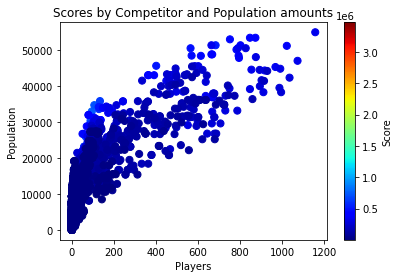

In [29]:
#Graph : Score by competitors vs poulation
score_gdf.plot.scatter(y='Population',
                     x='Players',
                      c= 'Score',
                      s= 50, #size of points
                     colormap='jet', sharex=False, title = 'Scores by Competitor and Population amounts')

<AxesSubplot:title={'center':'Scores by Competitor and Population amounts'}, xlabel='nb_commerces', ylabel='Population'>

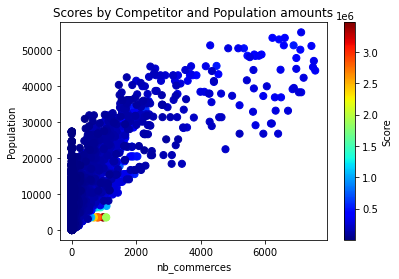

In [30]:
#Graph : Score by competitors vs population
score_gdf.plot.scatter(y='Population',
                     x='nb_commerces',
                      c= 'Score',
                      s= 50, #size of points
                     colormap='jet', sharex=False, title = 'Scores by Competitor and Population amounts')

<AxesSubplot:title={'center':'Scores by Competitor and Commerces amounts'}, xlabel='Players', ylabel='nb_commerces'>

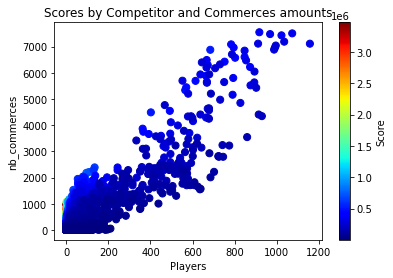

In [31]:
#Graph : Score by competitors vs poulation
score_gdf.plot.scatter(y='nb_commerces',
                     x='Players',
                      c= 'Score',
                      s= 50, #size of points
                     colormap='jet', sharex=False, title = 'Scores by Competitor and Commerces amounts')

## Map6 : Scores explained

In [32]:
if showmap: 

    m = folium.Map(location=[top_cities[city][1],top_cities[city][0]] )


    ##### Sample Points Layer
    _gdf = samples_gdf
    geometry_col = "sample_point"
    attrib_cols = ["nameofsample"]

    fg = folium.FeatureGroup("samples")

    points = prepare_points(_gdf, geometry_col  )
    attributes = prepare_attributes(_gdf,attrib_cols )

    for i , coordinates in enumerate(points):
        fg.add_child(folium.Marker(
            location = [coordinates[0],coordinates[1]],
            popup = html_popup(i ,attributes ),
            icon=folium.Icon(color='grey', icon='question', prefix='fa'))
        )
    fg.add_to(m)

    ##### Sample points Buffer Layer
    geometry_col = "sample_buffer"

    fg = folium.FeatureGroup(geometry_col)

    _gdf = _gdf.set_geometry(geometry_col)

    for _, r in _gdf.iterrows():
        sim_geo = gpd.GeoSeries(r[geometry_col])
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data=geo_j,
                            style_function=lambda x: {'fillColor': 'orange'})
        geo_j.add_to(fg)
    fg.add_to(m)
    #####

    ###### Iris Cloropleth Layer
    #Prepare json file for chloropleth map
    #https://www.roelpeters.be/plot-choropleth-map-geopandas-folium/
    iris_json = cake_gdf[['DCOMIRIS','neighborhood_shape']].sort_values(by='DCOMIRIS')#.head(2)
    iris_json = iris_json.drop_duplicates()
    iris_json = iris_json.rename(columns={"neighborhood_shape": "geometry"})
    iris_json = gpd.GeoSeries(iris_json.set_index('DCOMIRIS')['geometry']).to_json()


    folium.Choropleth(
    geo_data=iris_json,
    data = cake_gdf,
    name='Iris',
    columns=['DCOMIRIS','P17_POP'],
    key_on='id',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Population"
    ).add_to(m)

    ##### INitial Charging Points Layer
    _gdf = bbox_bmo_gdf
    geometry_col = "geometry_bkp"
    attrib_cols = ["name" ]

    fg = folium.FeatureGroup("ChargingStations")

    points = prepare_points(_gdf, geometry_col  )
    attributes = prepare_attributes(_gdf,attrib_cols )

    for i , coordinates in enumerate(points):
        fg.add_child(folium.Marker(
            location = [coordinates[0],coordinates[1]],
            popup = html_popup(i ,attributes ),
            icon=folium.Icon(color='green', icon='glyphicon-flash'))
        )
    fg.add_to(m)


    ##### Scored Points Layer
    _gdf = score_gdf
    geometry_col = "sample_point"
    attrib_cols = ["nameofsample", "Population", "nb_commerces", "Players","Score"]

    fg = folium.FeatureGroup("Resultats")

    points = prepare_points(_gdf, geometry_col  )
    attributes = prepare_attributes(_gdf,attrib_cols )

    for i , coordinates in enumerate(points):
        fg.add_child(folium.Marker(
            location = [coordinates[0],coordinates[1]],
            popup = html_popup(i ,attributes ),
            icon=folium.Icon(color='blue', icon='exclamation', prefix='fa'))
        )
    fg.add_to(m)


    folium.LayerControl().add_to(m)

    display(m)

In [33]:
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')

#logs_path
if overwrite : 
    score_gdf.to_parquet(logs_path) #COMMENT OUT if you want to overwrite
gdfx = gpd.read_parquet(logs_path)
gdfx = gdfx.append(score_gdf , ignore_index=True)
gdfx = gdfx.drop_duplicates() #we could save the same simulation twice
gdfx.to_parquet(logs_path)

C:\Users\J0102113\AppData\Local\Temp\ipykernel_17560\1784140979.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdfx = gdfx.append(score_gdf , ignore_index=True)


## Map7: Overall Simulations

In [34]:
if showmap: 

    m = folium.Map(location=[top_cities[city][1],top_cities[city][0]] )

    ##### Scored Points Layer
    _gdf = gdfx
    geometry_col = "sample_point"
    attrib_cols = ["nameofsample", "Population", "nb_commerces", "Players","Score"]

    fg = folium.FeatureGroup("Resultats")

    points = prepare_points(_gdf, geometry_col  )
    attributes = prepare_attributes(_gdf,attrib_cols )

    for i , coordinates in enumerate(points):
        fg.add_child(folium.Marker(
            location = [coordinates[0],coordinates[1]],
            popup = html_popup(i ,attributes ),
            icon=folium.Icon(color='blue', icon='exclamation', prefix='fa'))
        )
    fg.add_to(m)

    folium.LayerControl().add_to(m)

    display(m)

In [35]:
#At the end
filename = data_sources_paths_fr["m2a_communes"]
file = open(filename)
gdf_comm = gpd.read_file(file)
#gdf_comm = gdf_comm.loc[-gdf_comm["canton"].isna(),:] #si pas de canton alors c'est toute la de Mulhouse 
assert len(list(gdf_comm["code_insee"].unique())) == 39
gdf_comm.head()

,popu_munic,com_nom,canton,surface,arrondisse,cant_num,code_posta,nom,arrd_num,code_insee,epci,popu_a_par,popu_total,geometry
0,1451,DIETWILLER,BRUNSTATT,1107.570,MULHOUSE,2,68440,Dietwiller,4,68072,CA Mulhouse Alsace Agglomération,28,1479,"POLYGON ((7.47163 47.70432, 7.47156 47.70431, ..."
1,1489,ESCHENTZWILLER,BRUNSTATT,319.693,MULHOUSE,2,68440,Eschentzwiller,4,68084,CA Mulhouse Alsace Agglomération,46,1535,"POLYGON ((7.37760 47.70185, 7.37760 47.70187, ..."
2,804,GALFINGUE,KINGERSHEIM,535.677,MULHOUSE,8,68990,Galfingue,4,68101,CA Mulhouse Alsace Agglomération,17,821,"POLYGON ((7.19795 47.71207, 7.19810 47.71213, ..."
3,4833,HABSHEIM,RIXHEIM,1562.144,MULHOUSE,13,68440,Habsheim,4,68118,CA Mulhouse Alsace Agglomération,95,4928,"POLYGON ((7.39737 47.72982, 7.39777 47.72992, ..."
4,1314,HEIMSBRUNN,KINGERSHEIM,1057.841,MULHOUSE,8,68990,Heimsbrunn,4,68129,CA Mulhouse Alsace Agglomération,48,1362,"POLYGON ((7.20583 47.73506, 7.20704 47.73541, ..."


In [36]:
#Get points inside the polygons : 

#we will want to keep the points coordinates
#bbox_osm_gdf['node_coord'] = bbox_osm_gdf['osm_poi_geom']

gdfx.set_geometry('sample_point', inplace = True)
gdf_comm.set_geometry('geometry', inplace = True)

#change the order of the dfs 

#Logic : for each sample , one or more districts > buffers , that intersect with one or more competitors  
gdf_list = gpd.sjoin( gdfx, gdf_comm,  how="inner", predicate='intersects')

C:\Users\J0102113\AppData\Local\Temp\ipykernel_17560\306715819.py:12: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:2154
Right CRS: EPSG:4326

  gdf_list = gpd.sjoin( gdfx, gdf_comm,  how="inner", predicate='intersects')


In [37]:
keep_cols = ['nameofsample', 'com_nom','Districts', 'Population', 'Players', 'nb_commerces',
       'Score1', 'Score', 'sample_point', 'Simul_utc_time', 'country', 'city',
       'buffer_size', 'compet_source', 'popu_munic',  'surface',
       'arrondisse', 'cant_num', 'code_posta', 'nom', 'arrd_num', 'code_insee', 'popu_a_par', 'popu_total']
gdf_list = gdf_list.loc[:,keep_cols]

In [38]:
def keep_bests(df, sort_list, filter_list, num_keep ): 
    """Function to take only the highest value for each group 
    """
    df  = df.sort_values(  sort_list , ascending = [True, False])
    df_gb = df.groupby(sort_list[0]).head(num_keep).reset_index(drop=True)

    filter_upper = [elt.upper() for elt in filter_list]
    df_gb = df_gb.loc[df_gb[sort_list[0]].isin(filter_upper), : ]

    return df_gb

In [39]:
#communes avec une seule station #un nom a été modifié manuellement 
sort_list = ["com_nom", "Score"]
num_keep = 1

filter_list = ["Bantzenheim","Battenheim","Berrwiller","Bollwiller","Bruebach","Chalampé",
"Dietwiller","Eschentzwiller","Feldkirch","Flaxlanden","Galfingue","Heimsbrunn","Hombourg",
"Lutterbach","Morschwiller-le-Bas","Niffer","Ottmarsheim","Petit-Landau","Pulversheim","Reiningue",
"Richwiller","Ruelisheim","Staffelfelden","Steinbrunn-le-Bas","Ungersheim","Zillisheim","Zimmersheim"]

bests_1 = keep_bests(gdf_list, sort_list, filter_list, num_keep)
len(bests_1) == len(filter_list)* num_keep


True

In [40]:
num_keep = 2
filter_list = ['Baldersheim',  'Habsheim', 'Sausheim']
bests_2 = keep_bests(gdf_list, sort_list, filter_list, num_keep)
len(bests_2) == len(filter_list)* num_keep

True

In [41]:
num_keep = 3
filter_list = ["Illzach", "Kingersheim", "Pfastatt", "Riedisheim","Rixheim", "Wittelsheim", "Wittenheim", "BRUNSTATT-DIDENHEIM"]
bests_3 = keep_bests(gdf_list, sort_list, filter_list, num_keep)
len(bests_3) == len(filter_list)* num_keep


True

In [42]:
num_keep = 35
filter_list = ["Mulhouse" ]
bests_35 = keep_bests(gdf_list, sort_list, filter_list, num_keep)
len(bests_35) == len(filter_list)* num_keep

True

In [43]:
bests_locations = bests_1.append(bests_2).append(bests_3).append(bests_35)

C:\Users\J0102113\AppData\Local\Temp\ipykernel_17560\2879916926.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bests_locations = bests_1.append(bests_2).append(bests_3).append(bests_35)
C:\Users\J0102113\AppData\Local\Temp\ipykernel_17560\2879916926.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bests_locations = bests_1.append(bests_2).append(bests_3).append(bests_35)
C:\Users\J0102113\AppData\Local\Temp\ipykernel_17560\2879916926.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bests_locations = bests_1.append(bests_2).append(bests_3).append(bests_35)


In [44]:
bests_locations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 92 entries, 1 to 734
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   nameofsample    92 non-null     int64   
 1   com_nom         92 non-null     object  
 2   Districts       92 non-null     int64   
 3   Population      92 non-null     int32   
 4   Players         92 non-null     int64   
 5   nb_commerces    92 non-null     int32   
 6   Score1          92 non-null     int32   
 7   Score           92 non-null     int32   
 8   sample_point    92 non-null     geometry
 9   Simul_utc_time  92 non-null     object  
 10  country         92 non-null     object  
 11  city            92 non-null     object  
 12  buffer_size     92 non-null     float64 
 13  compet_source   92 non-null     object  
 14  popu_munic      92 non-null     int64   
 15  surface         92 non-null     float64 
 16  arrondisse      92 non-null     object  
 17  cant_num 

In [45]:
if showmap: 

    m = folium.Map(location=[top_cities[city][1],top_cities[city][0]] )

    ##### Scored Points Layer
    _gdf = gdf_list
    geometry_col = "sample_point"
    attrib_cols = ["nameofsample", "Population", "nb_commerces", "Players","Score"]

    fg = folium.FeatureGroup("Resultats")

    points = prepare_points(_gdf, geometry_col  )
    attributes = prepare_attributes(_gdf,attrib_cols )

    for i , coordinates in enumerate(points):
        fg.add_child(folium.Marker(
            location = [coordinates[0],coordinates[1]],
            popup = html_popup(i ,attributes ),
            icon=folium.Icon(color='blue', icon='exclamation', prefix='fa'))
        )
    fg.add_to(m)

    display(m)

In [46]:
def json_chloropleth(_gdf, key_col, geom_col): #returns a JSON
    """Prepare json file for chloropleth map
    https://www.roelpeters.be/plot-choropleth-map-geopandas-folium/"""

    file_json = _gdf.drop_duplicates()
    assert len(_gdf[key_col].unique()) == len(_gdf)

    file_json = file_json.rename(columns={"geom_col": "geometry"})
    file_json = gpd.GeoSeries(file_json.set_index(key_col)['geometry']).to_json()
    return file_json

json_file = json_chloropleth(gdf_comm, "code_insee", "geometry" )


In [47]:
#Get the best station per code_insee

def add_best(gdf, group_col, max_col): 
    _df_gb = gdf.groupby(group_col).agg({max_col : "max"})
    col_name = "best_" + max_col
    _df_gb = _df_gb.rename(columns={'Score': col_name})

    gdf_2 = gdf.merge(_df_gb, on = "code_insee" , how = "left" )

    return gdf_2

def extract_bests(_gdf, max_col):
    col_name = "best_" + max_col
    _gdf['besty'] = np.where(_gdf[max_col] == _gdf[col_name], True, False)
    _gdf_2 = _gdf.loc[_gdf["besty"] == True, :]
    return _gdf_2

gdf = gdf_list
group_col = "code_insee"
max_col = "Score"

_gdf = add_best(gdf, group_col, max_col)
gdf_bests = extract_bests(_gdf, max_col)


## MAP8: Best Scores for each Commune

In [48]:

# bmo_cols2 = ["name", "latitude","longitude", "project" ]

# ref_projects = bbox_bmo_gdf[bmo_cols2]


# ref_projects =geoparse(ref_projects, crs_proj )

# ref_projects.loc[-ref_projects["project"].isna(),:]

In [49]:
m = folium.Map(location=[top_cities[city][1],top_cities[city][0]] )

##### Scored Points Layer
_gdf = bests_locations
geometry_col = "sample_point"
attrib_cols = ["nameofsample", "Population", "nb_commerces", "Players","Score"]

fg = folium.FeatureGroup("Resultats")

points = prepare_points(_gdf, geometry_col  )
attributes = prepare_attributes(_gdf,attrib_cols )

for i , coordinates in enumerate(points):
    fg.add_child(folium.Marker(
        location = [coordinates[0],coordinates[1]],
        popup = html_popup(i ,attributes ),
        icon=folium.Icon(color='red', icon='exclamation', prefix='fa'))
    )
fg.add_to(m)

# ###### Iris Cloropleth Layer
#Prepare json file for chloropleth map
_gdf =  gdf_comm
key_col = "com_nom"

json_file = json_chloropleth(gdf_comm, key_col, "geometry" )

folium.Choropleth(
    geo_data=json_file,
    data = _gdf,
    name='Communes',
    columns=[key_col,"popu_total"],
    key_on='id',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="popu_total"
    ).add_to(m)

folium.LayerControl().add_to(m)

m  

In [50]:
def add_lat_lon(df): 
    df['longitude'] = df["sample_point"].x
    df['latitude'] = df["sample_point"].y
    return df

bests_locations = add_lat_lon(bests_locations)
bests_locations.head()

,nameofsample,com_nom,Districts,Population,Players,nb_commerces,Score1,Score,sample_point,Simul_utc_time,country,city,buffer_size,compet_source,popu_munic,surface,arrondisse,cant_num,code_posta,nom,arrd_num,code_insee,popu_a_par,popu_total,longitude,latitude
1,16075,BANTZENHEIM,1,1608,1,133,215472,215472,POINT (7.512 47.824),2022-05-20-12:18:14,FR,Mulhouse,0.01,bemoandprospects,1622,2120.731,MULHOUSE,13,68490,Bantzenheim,4,68020,35,1657,7.512375,47.824317
2,14271,BATTENHEIM,3,11392,6,177,2027776,337962,POINT (7.381 47.822),2022-05-20-12:18:14,FR,Mulhouse,0.01,bemoandprospects,1555,1687.284,MULHOUSE,13,68390,Battenheim,4,68022,14,1569,7.380775,47.822383
3,12141,BERRWILLER,1,1192,1,186,222904,222904,POINT (7.216 47.845),2022-05-20-12:18:14,FR,Mulhouse,0.01,bemoandprospects,1187,766.960,MULHOUSE,17,68500,Berrwiller,4,68032,36,1223,7.215949,47.845163
4,24865,BOLLWILLER,1,4027,1,416,1679259,1679259,POINT (7.257 47.857),2022-05-20-12:18:14,FR,Mulhouse,0.01,bemoandprospects,3979,863.404,MULHOUSE,17,68540,Bollwiller,4,68043,56,4035,7.256899,47.856558
5,25199,BRUEBACH,2,3847,3,153,592438,197479,POINT (7.357 47.703),2022-05-20-12:18:14,FR,Mulhouse,0.01,bemoandprospects,1060,700.802,MULHOUSE,2,68440,Bruebach,4,68055,25,1085,7.356643,47.702825


In [51]:
bests_locations.to_csv(output_path, index = False , sep = ',')